# Conductance estimation of Ohara 2017 by EfficientNet

In [1]:
import os, sys, copy, time
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import seaborn as sns
import multiprocessing
from functools import partial
import cv2
import skimage.io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
import torchaudio.transforms as AT
from torch.utils.data import  Dataset, TensorDataset, DataLoader
from efficientnet_pytorch import EfficientNet
from typing import Type, Any, Callable, Union, List, Optional
from IPython.display import HTML
from IPython import display
import librosa.display
from tqdm import tqdm
from sklearn.model_selection import train_test_split

random.seed(3)
np.random.seed(3)
torch.manual_seed(3)

print(torch.__version__)

C:\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


1.9.0


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
if (device.type == 'cuda') and (torch.cuda.device_count() >1):
    print("Multi GPU activate")
# device = torch.device('cpu')
device

device(type='cuda')

In [3]:
def minmax_normalization(x, min=1.0, max=100.0):
    return (x - min) / (max - min)

def inv_minmax_normalization(x_std, min=1, max=100):
    return x_std * (max - min) + min 

In [4]:
dataset_list = ["Dataset1" ]
models_dir = "Trained_models"
model_file_path = os.path.join(models_dir, f'params-150.pk')
output_dir1 = f'./{models_dir}/Results1_sim'        
if not os.path.exists(output_dir1):
    os.makedirs(output_dir1)
    print('"%s" has been created.'%(output_dir1))
output_dir2 = f'./{models_dir}/Results2_sim'        
if not os.path.exists(output_dir2):
    os.makedirs(output_dir2)
    print('"%s" has been created.'%(output_dir2))
    
batch_size = 128
epochs = 100
print_every = 1
window = 20
step_size = 10
window_type = 'avg'
emb_size = 512
d_model = 512
max_len = 2000

patience = 1000

"./Trained_models/Results1_sim" has been created.
"./Trained_models/Results2_sim" has been created.


In [5]:
x_test_OK = []
y_test_OK = []
x_test_NG = []
y_test_NG = []
for ds in dataset_list:
    ds_path = os.path.join("../Dataset", ds)    
    x_test_OK.append( np.load(os.path.join(ds_path, 'x_data_OK.npy')) )
    y_test_OK.append( np.load(os.path.join(ds_path, 'y_data_OK.npy')) )
    x_test_NG.append( np.load(os.path.join(ds_path, 'x_data_NG.npy')) )
    y_test_NG.append( np.load(os.path.join(ds_path, 'y_data_NG.npy')) )

x_test_OK = np.concatenate(x_test_OK, axis=0)
y_test_OK = np.concatenate(y_test_OK, axis=0)
x_test_NG = np.concatenate(x_test_NG, axis=0)
y_test_NG = np.concatenate(y_test_NG, axis=0)

print(x_test_OK.shape, y_test_OK.shape, x_test_NG.shape, y_test_NG.shape)

(948, 47) (948, 2) (55, 47) (55, 2)


In [6]:
start_time = time.time()



print("--- %s seconds ---"%(time.time()-start_time))

--- 0.0 seconds ---


In [7]:
x_test_OK = torch.tensor(x_test_OK).type(torch.float)
y_test_OK = torch.tensor(y_test_OK).type(torch.float)
x_test_NG = torch.tensor(x_test_NG).type(torch.float)
y_test_NG = torch.tensor(y_test_NG).type(torch.float)

y_test_OK = y_test_OK.view(-1, 2)
y_test_NG = y_test_NG.view(-1, 2)

print(x_test_OK.shape, x_test_NG.shape)
print(y_test_OK.shape, y_test_NG.shape)

torch.Size([948, 47]) torch.Size([55, 47])
torch.Size([948, 2]) torch.Size([55, 2])


In [8]:
class DefectInspector0(torch.nn.Module):
    def __init__(self,                            
                 in_size: int = 47,
                 out_size: int = 2,                                 
                 dropout: float = 0.1
                ):
        super(DefectInspector0, self).__init__()

        self.name = 'DefectInspector0'        
        self.out_size = out_size
        
        self.linear1 = torch.nn.Linear(in_size, 200)
        self.bn1 = torch.nn.BatchNorm1d(200)
        self.relu1 = torch.nn.ReLU(inplace=False)
        self.dropout1 = torch.nn.Dropout(dropout)
        
        self.linear2 = torch.nn.Linear(200, 200)
        self.bn2 = torch.nn.BatchNorm1d(200)
        self.relu2 = torch.nn.ReLU(inplace=False)
        self.dropout1 = torch.nn.Dropout(dropout)
        
        self.linear3 = torch.nn.Linear(200, 200)
        self.bn3 = torch.nn.BatchNorm1d(200)
        self.relu3 = torch.nn.ReLU(inplace=False)
        self.dropout1 = torch.nn.Dropout(dropout)
        
        self.final_linear = torch.nn.Linear(200, out_size, bias=True)  

    def forward(self, src: torch.Tensor): # src : (B, S, F)   
        
        out = self.linear1(src)       # (B, S, emb_size)      
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.linear2(out)       # (B, S, emb_size)      
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.linear3(out)       # (B, S, emb_size)      
        out = self.bn3(out)
        out = F.relu(out)
        
        return self.final_linear(out)       # (B, S, emb_size)      

In [9]:
# # val_ds = TensorDataset(x_val, y_val)
# test_ds = CustomDataset(x_test, y_test)
# test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4) 
# print(test_ds[0][0].shape, test_ds[0][1].shape)

In [10]:
from torch.utils.data import  TensorDataset, DataLoader
testOK_ds = TensorDataset(x_test_OK, y_test_OK)
testOK_loader = DataLoader(testOK_ds, batch_size=batch_size, shuffle=False, num_workers=0)

testNG_ds = TensorDataset(x_test_NG, y_test_NG)
testNG_loader = DataLoader(testNG_ds, batch_size=batch_size, shuffle=False, num_workers=0)

print(testOK_ds[0][0].shape, testOK_ds[0][1].shape)

torch.Size([47]) torch.Size([2])


In [15]:
model = DefectInspector0(in_size=x_test_OK.shape[1],
                         out_size=y_test_OK.shape[1])

In [16]:
checkpoint = torch.load(model_file_path) 
model.load_state_dict(checkpoint['model_state_dict'])

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model, device_ids=[0,1])
model.to(device)

print(f"Training time : {checkpoint['time']}s ({checkpoint['time']/60/60}h)")

Training time : 640.3473589420319s (0.17787426637278664h)


Best MSE for train dataset
1 : (147, 0.000186)
2 : (144, 0.000190)
3 : (133, 0.000213)
4 : (146, 0.000226)
5 : (141, 0.000233)
6 : (132, 0.000244)
7 : (142, 0.000255)
8 : (69, 0.000268)
9 : (128, 0.000280)
10 : (130, 0.000293)
Best MSE for validation dataset
1 : (20, 0.142797)
2 : (33, 0.147419)
3 : (12, 0.159975)
4 : (24, 0.164642)
5 : (11, 0.170769)
6 : (10, 0.174556)
7 : (34, 0.193469)
8 : (16, 0.203002)
9 : (89, 0.208682)
10 : (25, 0.211025)
----------------------------------------------------------------------------------------------------
0.514171838760376 0.00018615269800648093
2.542825222015381 0.14279697835445404


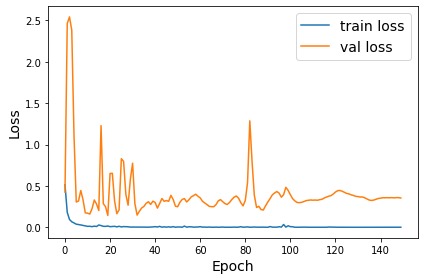

0.3544009327888489

In [17]:
train_loss_arr = np.array(checkpoint['train_loss_li'])
train_best_epoch = train_loss_arr.argsort() + 1
print("Best MSE for train dataset")
for i, epoch in enumerate(train_best_epoch[:10]):
    print("%d : (%d, %f)"%(i+1, epoch, train_loss_arr[epoch-1]))

print("="*50)

print("Best MSE for validation dataset")
val_loss_arr = np.array(checkpoint['val_loss_li'])
val_best_epoch = val_loss_arr.argsort() + 1
for i, epoch in enumerate(val_best_epoch[:10]):
    print("%d : (%d, %f)"%(i+1, epoch, val_loss_arr[epoch-1]))

print('-'*100)
print(train_loss_arr.max(), train_loss_arr.min())
print(val_loss_arr.max(), val_loss_arr.min())
# plt.title("Loss", fontsize=18) 
plt.xlabel( "Epoch", fontsize=14)
plt.ylabel( "Loss", fontsize=14)
# plt.ylim(0, 0.05)
plt.plot(checkpoint['train_loss_li'], label='train loss')
plt.plot(checkpoint['val_loss_li'], label='val loss')
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig( os.path.join(output_dir1, 'train_val_loss1.jpg'), dpi=199) 
plt.show()
checkpoint['val_loss_li'][-1]

In [18]:
# for i, loss in enumerate(zip(checkpoint['train_loss_li'], checkpoint['val_loss_li'])):
#     print(i+1, loss) 

In [19]:
def test(model, data_loader): 
    loss_sum = 0    
    criterion = nn.BCELoss()# nn.CrossEntropyLoss() #nn.MSELoss()
    nIter = 0
    nSuccess = 0
    with torch.no_grad(): 
        model.eval()   
        for i, data in enumerate(data_loader):
            output = model(data[0].to(device))     
            out = F.softmax(output, dim=1)            
            out_max, out_indices = torch.max(out.cpu(), dim=1)            
            target_max, target_indices = torch.max(data[1], dim=1)
#             print((out_indices!=target_indices))
#             print((out_indices!=target_indices).sum())
            nSuccess += (out_indices==target_indices).sum()
            loss = criterion(out, data[1].to(device))
            loss_sum += loss   
            nIter+=1                
    return nSuccess, loss_sum.item()/nIter

In [20]:
nSuccess, loss = test(model, testOK_loader)
print( f"%.2f %%"%(nSuccess/x_test_OK.shape[0]*100))

99.47 %


In [21]:
nSuccess, loss = test(model, testNG_loader)
print( f"%.2f %%"%(nSuccess/x_test_NG.shape[0]*100))

67.27 %


In [ ]:
print("Finish")